In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from modules import *

In [15]:
torch.cuda.is_available()

False

In [16]:
config = Config('config-Copy6.json')

In [45]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
config[...]

{'name': 'dropout_sd_skip_noshare',
 'batchsize': 12,
 'epoch': {'start': 161, 'end': 11000},
 'lr': {'initial': 0.001,
  'decay_rate': 0.9,
  'decay_step': 1,
  'override': None},
 'log_period': 1,
 'test': {'name': 'dropout_sd_skip_noshare',
  'epoch': 485,
  'out_prefix': 'drop_sd'}}

In [19]:
class Net_NOD_BN_Skip_SuperDeep(torch.nn.Module):
    def __init__(self):
        super().__init__()
        edge_feats = 2
        
        self.conv1 = NNConv(2, 32, Linear(edge_feats, 2*32), aggr='mean')
        self.conv2 = NNConv(32, 64, Linear(edge_feats, 32*64), aggr='mean')
        self.conv3 = NNConv(64, 64, Linear(edge_feats, 64*64), aggr='mean')
        self.conv4 = NNConv(64, 64, Linear(edge_feats, 64*64), aggr='mean')
        self.conv5 = NNConv(64, 64, Linear(edge_feats, 64*64), aggr='mean')
        self.conv6 = NNConv(64, 64, Linear(edge_feats, 64*64), aggr='mean')
        self.conv7 = NNConv(64, 64, Linear(edge_feats, 64*64), aggr='mean')
        self.conv8 = NNConv(64, 64, Linear(edge_feats, 64*64), aggr='mean')
        self.conv9 = NNConv(64, 64, Linear(edge_feats, 64*64), aggr='mean')
        self.conv10 = NNConv(64, 64, Linear(edge_feats, 64*64), aggr='mean')
        self.conv11 = NNConv(64, 32, Linear(edge_feats, 32*64), aggr='mean')
        self.conv12 = NNConv(32, 2, Linear(edge_feats, 2*32), aggr='mean')

        self.relu = nn.LeakyReLU()
        self.bn1 = BatchNorm(32)
        self.bn2 = BatchNorm(64)
        self.bn3 = BatchNorm(64)
        self.bn4 = BatchNorm(64)
        self.bn5 = BatchNorm(64)
        self.bn6 = BatchNorm(64)
        self.bn7 = BatchNorm(64)
        self.bn8 = BatchNorm(64)
        self.bn9 = BatchNorm(64)
        self.bn10 = BatchNorm(64)
        self.bn11 = BatchNorm(32)
        
        self.dp1 = Dropout(0.2)
        self.dp2 = Dropout(0.2)
        self.dp3 = Dropout(0.2)
        self.dp4 = Dropout(0.2)
        self.dp5 = Dropout(0.2)
        self.dp6 = Dropout(0.2)
        self.dp7 = Dropout(0.2)
        self.dp8 = Dropout(0.2)
        self.dp9 = Dropout(0.2)
        self.dp10 = Dropout(0.2)



#         self.conv4 = NNConv(16+32+64, 128, Linear(2, (16+32+64)*128))
#         self.conv5 = NNConv(128,2,Linear(2,128*2))
#         self.conv2 = NNConv(16,2,Linear(2,16*2))

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        x1 = self.dp1(self.relu(self.bn1(self.conv1(x, edge_index, edge_attr))))
        x2 = self.dp2(self.relu(self.bn2(self.conv2(x1, edge_index, edge_attr))))
        x3 = self.dp3(self.relu(self.bn3(self.conv3(x2, edge_index, edge_attr))))
        x4 = self.dp4(self.relu(self.bn4(self.conv4(x3, edge_index, edge_attr))))
        
        res_x4 = x2+x4
        
        x5 = self.dp5(self.relu(self.bn5(self.conv5(res_x4, edge_index, edge_attr))))
        x6 = self.dp6(self.relu(self.bn6(self.conv6(x5, edge_index, edge_attr))))
                            
        res_x6 = res_x4+x6
                         
        x7 = self.dp7(self.relu(self.bn7(self.conv7(res_x6, edge_index, edge_attr))))
        x8 = self.dp8(self.relu(self.bn8(self.conv8(x7, edge_index, edge_attr))))
                            
        res_x8 = res_x6+x8
                         
        x9 = self.dp9(self.relu(self.bn9(self.conv9(res_x8, edge_index, edge_attr))))
        x10 = self.dp10(self.relu(self.bn10(self.conv10(x9, edge_index, edge_attr))))
                            
        res_x10 = res_x8+x10
                                        
        x11 = self.relu(self.bn11(self.conv11(res_x10, edge_index, edge_attr)))
        x12 = self.conv12(x11, edge_index, edge_attr)

        return x12

In [20]:
def load_processed_data():
    if os.path.isfile('G_list.pickle') and os.path.isfile('data_list.pickle'):
        G_list = pickle.load(open('G_list.pickle', 'rb'))
        data_list = pickle.load(open('data_list.pickle', 'rb'))
    else:
        if not os.path.isfile('data_index.txt'):
            shuffle_rome('data_index.txt')
        rome = load_rome('data_index.txt')
        G_list, data_list = convert_datalist(rome)
        pickle.dump(G_list, open('G_list.pickle', 'wb'))
        pickle.dump(data_list, open('data_list.pickle', 'wb'))
    return G_list, data_list

In [9]:
G_list, data_list = load_processed_data()

In [10]:
loader = DataLoader(data_list[:10000], batch_size=config['batchsize'],shuffle=True)
loss_ep = []

In [ ]:
start_epoch = config['epoch']['start']
if start_epoch == 1:
    model = Net_NOD_BN_Skip_SuperDeep().to(device)
else:
    model = torch.load(f"../ckpt_{config['name']}/epoch_{start_epoch}.pt").to(device)
criterion = EnergyLossVectorized()
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr']['initial'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, 
                                            step_size=config['lr']['decay_step'], 
                                            gamma=config['lr']['decay_rate'])
print("=" * 50, file=open(f"{config['name']}.log", "a"))
epoch = start_epoch
while True:
    if config['lr']['override'] is not None:
        optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr']['override'])
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, 
                                                    step_size=config['lr']['decay_step'], 
                                                    gamma=config['lr']['decay_rate'])
    train_loss = train(model, criterion, optimizer, loader, data_list, device)
    loss_ep.append(loss)
    scheduler.step()
    if epoch == 1 and config['log_period'] != 1:
        print(epoch, loss, scheduler.get_lr(), file=open(f"{config['name']}.log", "a"))
    if epoch % config['log_period'] == 0:
        torch.save(model, f"../ckpt_{config['name']}/epoch_{epoch}.pt")
        test_loss = []
        for val_idx in range(11000, len(G_list)):
            node_pos,loss = evaluate(model, data_list[val_idx],criterion,device)
            test_loss.append(loss)
        print(f'{epoch}, train: {train_loss}, val:{np.mean(test_loss)}，{scheduler.get_lr()}', file=open(f"{config['name']}.log", "a"))
    if epoch == config['epoch']['end']:
        break
    epoch += 1

# Performance Testing

In [47]:
model = torch.load(f'../ckpt_{config["test"]["name"]}/epoch_{config["test"]["epoch"]}.pt', map_location=torch.device(device))
criterion = EnergyLossVectorized()
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [ ]:
folder_name = f'{config["test"]["name"]}_test'
for test_idx in tqdm(list(chain(range(0, 10000, 10), range(10000, 11000)))):
    G_vis = G_list[test_idx]
    node_pos,loss = evaluate(model, data_list[test_idx],criterion,device)
    graph_vis(G_vis, node_pos, f'{folder_name}/{config["test"]["out_prefix"]}_model_{test_idx}_{loss}.png') 
    node_pos = nx.nx_agraph.graphviz_layout(G_vis, prog='neato')
    plt.figure()
    nx.draw(G_vis, node_pos)
    plt.savefig(f'{folder_name}/{test_idx}.png')

In [12]:
losses = []
for test_idx in tqdm(range(10000, len(G_list))):
    G_vis = G_list[test_idx]
    node_pos, loss = evaluate(model, data_list[test_idx], criterion, device)
    losses += [loss]

In [13]:
np.mean(losses), np.std(losses)

(5.167400391900719, 5.443973138798838)

In [68]:
truth_loss = 0
pred_loss = 0
for idx in tqdm(range(10000, 11000)):
    pred, loss = evaluate(model, data_list[idx], criterion, device)
    pos_map = nx.nx_agraph.graphviz_layout(G_list[idx], prog='neato')

    pred_mean, pred_std = pred.mean(axis=0), pred.std()
    truth = np.array(list(pos_map.values()))
    truth_mean, truth_std = truth.mean(axis=0), truth.std()
    norm_truth = (truth - truth_mean) / truth_std
    scaled_truth = norm_truth * pred_std + pred_mean

    truth_loss += criterion(torch.tensor(scaled_truth), data_list[idx])
    pred_loss += criterion(torch.tensor(pred), data_list[idx])
    
truth_loss / 1000, pred_loss / 1000

(tensor(5.4483, dtype=torch.float64), tensor(5.3517))

In [20]:
type(data_list[9999].x)

torch.Tensor

In [ ]:
iterations = 5
losses = []
folder_name = f'{config["test"]["name"]}_iterative_test'
for test_idx in tqdm(range(10000, len(G_list))):
    G_vis = G_list[test_idx]
    node_pos = nx.nx_agraph.graphviz_layout(G_vis, prog='neato')
    plt.figure()
    nx.draw(G_vis, node_pos)
    plt.savefig(f'{folder_name}/{test_idx}.png')
    for i in range(iterations):
        node_pos, loss = evaluate(model, data_list[test_idx], criterion, device) 
        data_list[test_idx].x = torch.tensor(node_pos,dtype=torch.float)
    losses += [loss]
    graph_vis(G_vis, node_pos, f'{folder_name}/{config["test"]["out_prefix"]}_iter_model_{test_idx}_{loss}.png')

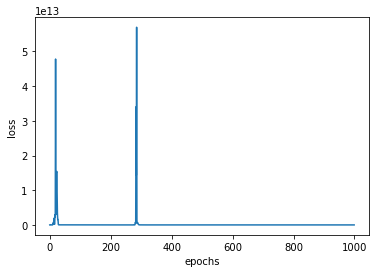

In [174]:
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(loss_ep[:1000])
plt.show()

In [10]:
np

3.3333333333333335